In [1]:
import cv2     # for capturing videos
import math   # for mathematical operations
import matplotlib.pyplot as plt    # for plotting the images
%matplotlib inline
import pandas as pd
import tensorflow
from tensorflow.keras.preprocessing import image   # for preprocessing the images
import numpy as np    # for mathematical operations
from tensorflow.python.keras.utils import np_utils
from skimage.transform import resize   # for resizing images

Step – 1: Read the video, extract frames from it and save them as images

In [7]:
count = 0
videoFile = "Tom and jerry.mp4"
cap = cv2.VideoCapture(videoFile)   # capturing the video from the given path
frameRate = cap.get(5) #frame rate
print(frameRate)
x=1
while(cap.isOpened()):
    frameId = cap.get(1) #current frame number
    ret, frame = cap.read()
#     print(frameRate,ret,frame)
    if (ret != True):
        break
    if (frameId % math.floor(frameRate) == 0):
        filename ="frame%d.jpg" % count;count+=1
        cv2.imwrite('train/'+filename, frame)
cap.release()
print ("Done!")

30.0
Done!


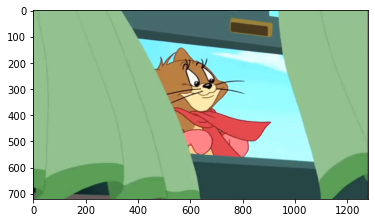

In [9]:
img = plt.imread('train/frame0.jpg')   # reading image using its name
plt.imshow(img)

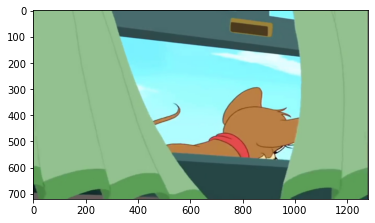

In [11]:
img = plt.imread('train/frame1.jpg')   # reading image using its name
plt.imshow(img)

Step – 2: Label a few images for training the model

Keep in mind that there could be frames when neither TOM nor JERRY are present. So, we will treat it as a multi-class classification problem. The classes which I have defined are:

0 – neither JERRY nor TOM

1 – for JERRY

2 – for TOM

In [13]:
data = pd.read_csv('mapping.csv')     # reading the csv file
data.head()      # printing first five rows of the file


,Image_ID,Class
0,frame0.jpg,1
1,frame1.jpg,1
2,frame2.jpg,2
3,frame3.jpg,2
4,frame4.jpg,2


Our next step is to read the images which we will do based on their names, aka, the Image_ID column.



In [15]:
X = [ ]     # creating an empty array
for img_name in data.Image_ID:
    img = plt.imread('train/' + img_name)
    X.append(img)  # storing each image in array X
X = np.array(X)    # converting list to array

well! We now have the images with us. Remember, we need two things to train our model:

Training images, and
Their corresponding class
Since there are three classes, we will one hot encode them using the to_categorical() function of keras.utils.



In [16]:
y = data.Class
dummy_y = np_utils.to_categorical(y)    # one hot encoding Classes


In [17]:
dummy_y[:5]

array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

We will be using a VGG16 pretrained model which takes an input image of shape (224 X 224 X 3). Since our images are in a different size, we need to reshape all of them. We will use the resize() function of skimage.transform to do this.

In [18]:
image = []
for i in range(0,X.shape[0]):
    a = resize(X[i], preserve_range=True, output_shape=(224,224)).astype(int)      # reshaping to 224*224*3
    image.append(a)
X = np.array(image)

All the images have been reshaped to 224 X 224 X 3. But before passing any input to the model, we must preprocess it as per the model’s requirement. Otherwise, the model will not perform well enough. Use the preprocess_input() function of keras.applications.vgg16 to perform this step.

In [19]:
from keras.applications.vgg16 import preprocess_input
X = preprocess_input(X, mode='tf')      # preprocessing the input data

Using TensorFlow backend.


We also need a validation set to check the performance of the model on unseen images. We will make use of the train_test_split() function of the sklearn.model_selection module to randomly divide images into training and validation set.

In [20]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X, dummy_y, test_size=0.3, random_state=42)    # preparing the validation set

Step 3: Building the model

The next step is to build our model. As mentioned, we shall be using the VGG16 pretrained model for this task. Let us first import the required libraries to build the model:

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Dense, InputLayer, Dropout

We will now load the VGG16 pretrained model and store it as base_model:

In [22]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))    # include_top=False to remove the top layer

We will make predictions using this model for X_train and X_valid, get the features, and then use those features to retrain the model.

In [23]:
X_train = base_model.predict(X_train)
X_valid = base_model.predict(X_valid)
X_train.shape, X_valid.shape

((208, 7, 7, 512), (90, 7, 7, 512))

The shape of X_train and X_valid is (208, 7, 7, 512), (90, 7, 7, 512) respectively. In order to pass it to our neural network, we have to reshape it to 1-D.

In [24]:
X_train = X_train.reshape(208, 7*7*512)      # converting to 1-D
X_valid = X_valid.reshape(90, 7*7*512)

We will now preprocess the images and make them zero-centered which helps the model to converge faster.

In [25]:
train = X_train/X_train.max()      # centering the data
X_valid = X_valid/X_train.max()

Finally, we will build our model. This step can be divided into 3 sub-steps:

1. Building the model
2. Compiling the model
3. Training the model

In [26]:
# i. Building the model
model = Sequential()
model.add(InputLayer((7*7*512,)))    # input layer
model.add(Dense(units=1024, activation='sigmoid')) # hidden layer
model.add(Dense(3, activation='softmax'))    # output layer

Let’s check the summary of the model using the summary() function:

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1024)              25691136  
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 3075      
Total params: 25,694,211
Trainable params: 25,694,211
Non-trainable params: 0
_________________________________________________________________


We have a hidden layer with 1,024 neurons and an output layer with 3 neurons (since we have 3 classes to predict). Now we will compile our model:

In [28]:
# ii. Compiling the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In the final step, we will fit the model and simultaneously also check its performance on the unseen images, i.e., validation images:

In [29]:
# iii. Training the model
model.fit(train, y_train, epochs=100, validation_data=(X_valid, y_valid))

Train on 208 samples, validate on 90 samples
Epoch 1/100
208/208 [==============================] - 2s 8ms/sample - loss: 1.2303 - accuracy: 0.5288 - val_loss: 1.2904 - val_accuracy: 0.6333
Epoch 2/100
208/208 [==============================] - 0s 886us/sample - loss: 0.5535 - accuracy: 0.7885 - val_loss: 0.7453 - val_accuracy: 0.5889
Epoch 3/100
208/208 [==============================] - 0s 879us/sample - loss: 0.2992 - accuracy: 0.8702 - val_loss: 0.5910 - val_accuracy: 0.7889
Epoch 4/100
208/208 [==============================] - 0s 970us/sample - loss: 0.1644 - accuracy: 0.9327 - val_loss: 0.4016 - val_accuracy: 0.8111
Epoch 5/100
208/208 [==============================] - 0s 1ms/sample - loss: 0.1066 - accuracy: 0.9663 - val_loss: 0.3856 - val_accuracy: 0.8333
Epoch 6/100
208/208 [==============================] - 0s 1ms/sample - loss: 0.0642 - accuracy: 0.9952 - val_loss: 0.3758 - val_accuracy: 0.8444
Epoch 7/100
208/208 [==============================] - 0s 992us/sample - loss: 

Done !

In [32]:
count = 0
videoFile = "Tom and Jerry 3.mp4"
cap = cv2.VideoCapture(videoFile)
frameRate = cap.get(5) #frame rate
x=1
while(cap.isOpened()):
    frameId = cap.get(1) #current frame number
    ret, frame = cap.read()
    if (ret != True):
        break
    if (frameId % math.floor(frameRate) == 0):
        filename ="test%d.jpg" % count;count+=1
        cv2.imwrite('test/'+filename, frame)
cap.release()
print ("Done!")

Done!


In [33]:
test = pd.read_csv('test.csv')

In [34]:
test_image = []
for img_name in test.Image_ID:
    img = plt.imread('test/' + img_name)
    test_image.append(img)
test_img = np.array(test_image)

In [35]:
test_image = []
for i in range(0,test_img.shape[0]):
    a = resize(test_img[i], preserve_range=True, output_shape=(224,224)).astype(int)
    test_image.append(a)
test_image = np.array(test_image)


In [36]:
# preprocessing the images
test_image = preprocess_input(test_image, mode='tf')

# extracting features from the images using pretrained model
test_image = base_model.predict(test_image)

# converting the images to 1-D form
test_image = test_image.reshape(186, 7*7*512)

# zero centered images
test_image = test_image/test_image.max()

In [37]:
predictions = model.predict_classes(test_image)

In [38]:
print("The screen time of JERRY is", predictions[predictions==1].shape[0], "seconds")
print("The screen time of TOM is", predictions[predictions==2].shape[0], "seconds")

The screen time of JERRY is 8 seconds
The screen time of TOM is 96 seconds


more accurate mode

In [39]:
import cv2
import math
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
from keras.preprocessing import image
import numpy as np
from skimage.transform import resize

In [2]:
count = 0
videoFile = "Tom and jerry.mp4"
cap = cv2.VideoCapture(videoFile)
frameRate = cap.get(5) #frame rate
x=1
while(cap.isOpened()):
    frameId = cap.get(1) #current frame number
    ret, frame = cap.read()
    if (ret != True):
        break
    if (frameId % math.floor(frameRate) == 0):
        filename ="frame%d.jpg" % count;count+=1
        cv2.imwrite(filename, frame)
cap.release()
print ("Done!")

Done!


In [3]:
count = 0
videoFile = "Tom and Jerry 3.mp4"
cap = cv2.VideoCapture(videoFile)
frameRate = cap.get(5) #frame rate
x=1
while(cap.isOpened()):
    frameId = cap.get(1) #current frame number
    ret, frame = cap.read()
    if (ret != True):
        break
    if (frameId % math.floor(frameRate) == 0):
        filename ="test%d.jpg" % count;count+=1
        cv2.imwrite(filename, frame)
cap.release()
print ("Done!")

Done!


In [11]:
data = pd.read_csv('mapping.csv')
test = pd.read_csv('test.csv')

In [69]:
X = []
for img_name in data.Image_ID:
    img = plt.imread('train/' + img_name)
    X.append(img)
X = np.array(X)

In [68]:
test_image = []
for img_name in test.Image_ID:
    img = plt.imread('test/' + img_name)
    test_image.append(img)
test_img = np.array(test_image)

In [71]:
# test_img

In [72]:
from tensorflow.python.keras.utils import np_utils
train_y = np_utils.to_categorical(data.Class)
# test_y = np_utils.to_categorical(test.Class)

In [73]:
image = []
for i in range(0,X.shape[0]):
    a = resize(X[i], preserve_range=True, output_shape=(224,224,3)).astype(int)
    image.append(a)
X = np.array(image)

In [74]:
test_image = []
for i in range(0,test_img.shape[0]):
    a = resize(test_img[i], preserve_range=True, output_shape=(224,224)).astype(int)
    test_image.append(a)
test_image = np.array(test_image)

In [75]:
from keras.applications.vgg16 import preprocess_input
X = preprocess_input(X, mode='tf')
test_image = preprocess_input(test_image, mode='tf')

In [76]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X, train_y, test_size=0.3, random_state=42)

In [77]:
from keras.models import Sequential
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, InputLayer, Dropout

In [78]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [79]:
X_train = base_model.predict(X_train)
X_valid = base_model.predict(X_valid)
test_image = base_model.predict(test_image)

In [80]:
X_train = X_train.reshape(208, 7*7*512)
X_valid = X_valid.reshape(90, 7*7*512)
test_image = test_image.reshape(186, 7*7*512)

In [81]:
train = X_train/X_train.max()
X_valid = X_valid/X_train.max()
test_image = test_image/test_image.max()

In [82]:
model = Sequential()
model.add(InputLayer((7*7*512,)))    # input layer
model.add(Dense(units=1024, activation='sigmoid'))   # hidden layer
model.add(Dropout(0.5))      # adding dropout
model.add(Dense(units=512, activation='sigmoid'))    # hidden layer
model.add(Dropout(0.5))      # adding dropout
model.add(Dense(units=256, activation='sigmoid'))    # hidden layer
model.add(Dropout(0.5))      # adding dropout
model.add(Dense(3, activation='softmax'))            # output layer

In [83]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [84]:
from sklearn.utils.class_weight import compute_class_weight, compute_sample_weight
class_weights = compute_class_weight('balanced',np.unique(data.Class), data.Class)  # computing weights of different classes

In [85]:
from keras.callbacks import ModelCheckpoint
filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]      # model check pointing based on validation loss

In [86]:
model.fit(train, y_train, epochs=100, validation_data=(X_valid, y_valid), class_weight=class_weights, callbacks=callbacks_list)

Train on 208 samples, validate on 90 samples
Epoch 1/100
208/208 [==============================] - 3s 15ms/step - loss: 1.2427 - accuracy: 0.4038 - val_loss: 1.0607 - val_accuracy: 0.3667

Epoch 00001: val_loss improved from inf to 1.06072, saving model to weights.best.hdf5
Epoch 2/100
208/208 [==============================] - 1s 3ms/step - loss: 1.1497 - accuracy: 0.4471 - val_loss: 1.0214 - val_accuracy: 0.5556

Epoch 00002: val_loss improved from 1.06072 to 1.02144, saving model to weights.best.hdf5
Epoch 3/100
208/208 [==============================] - 1s 2ms/step - loss: 1.0803 - accuracy: 0.4904 - val_loss: 0.9957 - val_accuracy: 0.5444

Epoch 00003: val_loss improved from 1.02144 to 0.99573, saving model to weights.best.hdf5
Epoch 4/100
208/208 [==============================] - 0s 2ms/step - loss: 1.0204 - accuracy: 0.5048 - val_loss: 0.9196 - val_accuracy: 0.5889

Epoch 00004: val_loss improved from 0.99573 to 0.91958, saving model to weights.best.hdf5
Epoch 5/100
208/208 [=

In [88]:
model.load_weights("weights.best.hdf5")

In [89]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [67]:
scores = model.evaluate(test_image, test_y)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

NameError: name 'test_y' is not defined

In [128]:
# Import packages
import os
import cv2
import numpy as np
import tensorflow as tf
import sys

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")

# Import utilites
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

# Name of the directory containing the object detection module we're using
MODEL_NAME = 'weights.best.hdf5'
VIDEO_NAME = 'Tom and Jerry 3.mp4'

# Grab path to current working directory
CWD_PATH = os.getcwd()

# Path to frozen detection graph .pb file, which contains the model that is used
# for object detection.
PATH_TO_CKPT = os.path.join(CWD_PATH,MODEL_NAME,'frozen_inference_graph.pb')

# Path to label map file
PATH_TO_LABELS = os.path.join(CWD_PATH,'training','labelmap.pbtxt')

# Path to video
PATH_TO_VIDEO = os.path.join(CWD_PATH,'testing/videos',VIDEO_NAME)

# Number of classes the object detector can identify
NUM_CLASSES = 2

# Load the label map.
# Label maps map indices to category names, so that when our convolution
# network predicts `5`, we know that this corresponds to `king`.
# Here we use internal utility functions, but anything that returns a
# dictionary mapping integers to appropriate string labels would be fine
# label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
# categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
# category_index = label_map_util.create_category_index(categories)

# Load the Tensorflow model into memory.
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.io.gfile.GFile(PATH_TO_CKPT, 'r') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

    sess = tf.compat.v1.Session(graph=detection_graph)

# Define input and output tensors (i.e. data) for the object detection classifier

# Input tensor is the image
image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')

# Output tensors are the detection boxes, scores, and classes
# Each box represents a part of the image where a particular object was detected
detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')

# Each score represents level of confidence for each of the objects.
# The score is shown on the result image, together with the class label.
detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')

# Number of objects detected
num_detections = detection_graph.get_tensor_by_name('num_detections:0')

# Open video file
video = cv2.VideoCapture(PATH_TO_VIDEO)

while(video.isOpened()):

    # Acquire frame and expand frame dimensions to have shape: [1, None, None, 3]
    # i.e. a single-column array, where each item in the column has the pixel RGB value
    ret, frame = video.read()
    frame_expanded = np.expand_dims(frame, axis=0)

    # Perform the actual detection by running the model with the image as input
    (boxes, scores, classes, num) = sess.run(
        [detection_boxes, detection_scores, detection_classes, num_detections],
        feed_dict={image_tensor: frame_expanded})

    # Draw the results of the detection (aka 'visulaize the results')
    vis_util.visualize_boxes_and_labels_on_image_array(
        frame,
        np.squeeze(boxes),
        np.squeeze(classes).astype(np.int32),
        np.squeeze(scores),
        category_index,
        use_normalized_coordinates=True,
        line_thickness=8,
        min_score_thresh=0.80)

    # All the results have been drawn on the frame, so it's time to display it.
    cv2.imshow('Object detector', frame)

    # Press 'q' to quit
    if cv2.waitKey(1) == ord('q'):
        break

# Clean up
video.release()
cv2.destroyAllWindows()

AttributeError: module 'tensorflow' has no attribute 'GraphDef'

In [114]:
tf.io.gfile.GFile(PATH_TO_CKPT, 'rb'
)

In [127]:
from official.wide_deep import census_dataset
from official.wide_deep import census_main

census_dataset.download("/tmp/census_data/")

ModuleNotFoundError: No module named 'official'